In [1]:
!nvidia-smi

Sun Oct 15 06:20:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:8C:00.0 Off |                  Off |
| N/A   28C    P0    24W / 250W |      4MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Installing libraries

In [2]:
# %pip install transformers
%pip install -q "torch==2.1.0+cu121" -f "https://download.pytorch.org/whl/torch_stable.html"

In [3]:
%pip install -q "torchvision==0.16.0+cu121" -f "https://download.pytorch.org/whl/torch_stable.html"

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 2.1.0+cu121 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 2.1.0+cu121 which is incompatible.


In [4]:
%pip install nltk pymystem3

Defaulting to user installation because normal site-packages is not writeable
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 2.1.0+cu121 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 2.1.0+cu121 which is incompatible.


## Extract images from video

In [13]:
import cv2
import os

VIDEO_NAME = "13.mp4"
VIDEO_PATH = os.path.join("videos", VIDEO_NAME)
IMAGES_PATH = os.path.join("extracted_images", VIDEO_NAME.split('.')[0])

In [14]:
def extractImages(video_path: str, images_path: str):
    os.makedirs(images_path, exist_ok=True)

    # Frame number
    count = 0

    # Read the video
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    success = True

    # Start converting the video
    print("Converting video..\n")
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC, (count*1000)) 
        success, image = vidcap.read()
        if success:
            cv2.imwrite(os.path.join(images_path, f"frame_{count}.jpg"), image)     # save frame as JPEG file
        count = count + 1
    
    print("Video is converted")


extractImages(VIDEO_PATH, IMAGES_PATH)

Converting video..

Video is converted


In [15]:
len(os.listdir(IMAGES_PATH))

2231

## Import libraries

In [16]:
from diffusers import StableDiffusionImg2ImgPipeline, EulerDiscreteScheduler
from pathlib import Path
from PIL import Image
import torch
import re

import os

model_id = "stabilityai/stable-diffusion-2"
# model_id = "runwayml/stable-diffusion-v1-5"

## Choose images to generate on

In [17]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(59)

IMAGES_PATH = "extracted_images/13/"

images = os.listdir(IMAGES_PATH)
images_paths = [os.path.join(IMAGES_PATH, img) for img in images]
images_paths_chosen = np.random.choice(images_paths, size=3, replace=False)

init_images = [Image.open(image).convert("RGB").resize((800,800)) for image in images_paths_chosen]
len(init_images)

3

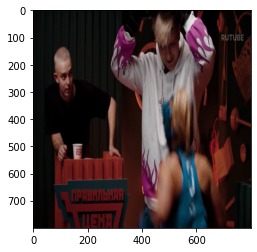

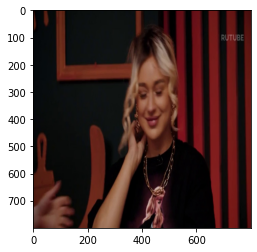

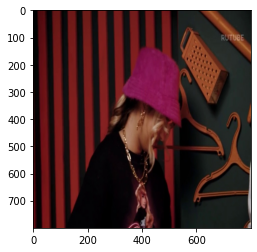

In [18]:
%matplotlib inline

for img in init_images:
    plt.imshow(img)
    plt.show()

## Choose prompts

In [19]:
from txt_prep_script import TextPreparator

RAW_DESC = "С вами Макс Климток и это шоу Правильная цена! Шоу, в котором участники зарабатывают баллы, угадывая правильные цены товаров и услуг. Сегодня мы узнаем, как в ценах ориентируются Настя Bad Barbie, Женя Ершов и Герман Гласс. За просмотр шоу вы также можете заплатить свою цену - поставить лайк, подписаться на канал и оставить комментарий."

tp = TextPreparator()
cleared_desc = tp.process_single_text(RAW_DESC)
cleared_desc

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'климток участник товар услуга сегодня настя ершов герман гласс просмотр также канал'

In [20]:
# cleared_desc = 'серия легенда протеин мышца организм россия'
# len(cleared_desc)

In [42]:
genres = [
    "No Style",
    "Random Style",
    "Photograph",
    "Modern Fashion",
    "Anime Style",
    "Comic Strip",
    "Art Nouveau"
]

prompts = [
    f"High Quality Album Cover {genres[2]} {cleared_desc}",
    f"High Quality Album Cover {genres[2]} {cleared_desc}",
    f"High Quality Album Cover {genres[2]} {cleared_desc}"
]

negative_prompts = [
    "blurry, dark photo, blue, nsfw content, text",
    "blurry, dark photo, blue, nsfw content, text",
    "blurry, dark photo, blue, nsfw content, text"
]

In [43]:
generated_path = "./generated_covers/new"

os.makedirs(generated_path, exist_ok=True)

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"

try:
    scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
except:
    pass

pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [45]:
steps = 100
scale = 9
num_images_per_prompt = 1
seed = 59
generator = torch.Generator(device=device).manual_seed(seed)

In [46]:
output = pipe(
    prompts,
    negative_prompt=negative_prompts,
    image=init_images,
    num_inference_steps=steps,
    guidance_scale=scale,
    num_images_per_prompt=num_images_per_prompt,
    generator=generator
)

Token indices sequence length is longer than the specified maximum sequence length for this model (90 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['� также канал', '� также канал', '� также канал']


  0%|          | 0/80 [00:00<?, ?it/s]

In [47]:
for idx, image in enumerate(output.images):
    image_name = f'{idx}.png'
    image_path = os.path.join(generated_path, image_name)
    image.save(image_path)

Insert face

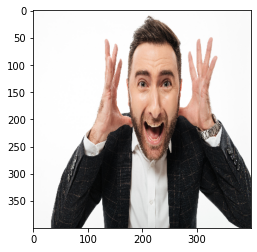

In [48]:
face_arr = cv2.imread("close-up-portrait-mad-young-bearded-man.jpg")
face_arr = cv2.cvtColor(face_arr, cv2.COLOR_BGR2RGB)
face_arr = cv2.resize(face_arr, (400, 400))

plt.imshow(face_arr)
plt.show()

In [33]:
print(face_arr.shape)

(400, 400, 3)


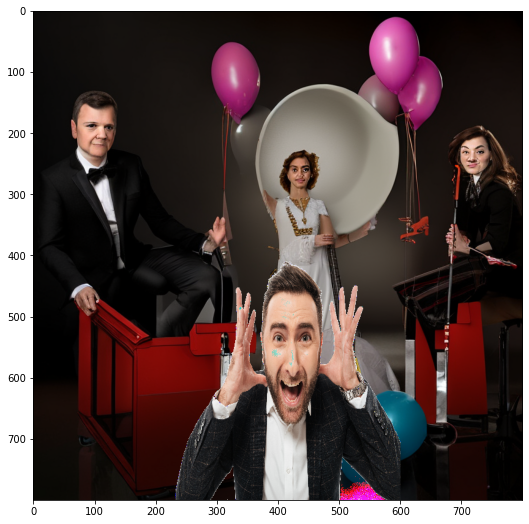

In [51]:
out_image = np.array(output.images[0])
out_image.shape

for row in range(400):
    for col in range(400):
        for channel in range(3):
            if face_arr[row][col][channel] <= 245:
                out_image[400 + row, 200 + col, channel] = face_arr[row][col][channel]

plt.figure(figsize=(13,9))
plt.imshow(out_image)
plt.show()

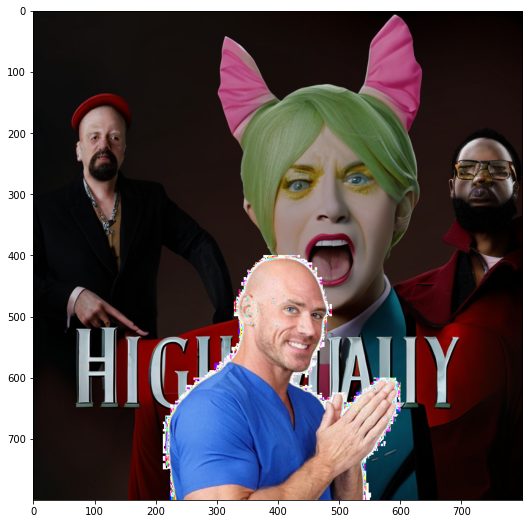

In [33]:
plt.figure(figsize=(13,9))
plt.imshow(out_image)
plt.show()

In [35]:
plt.imsave("bald_braz_with_cover.png", out_image)

## Generate avatar and banner

In [4]:
from diffusers import StableDiffusionPipeline


pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [6]:
steps = 100
scale = 9
num_images_per_prompt = 1
seed = 59
generator = torch.Generator(device='cuda').manual_seed(seed)

desc_most_popular = "protein anton push-ups muscle channel"

output = pipe(
    [f"High Quality Banner {desc_most_popular}"],
    negative_prompt=["blurry, dark photo, blue, nsfw content, text"],
    height=880, width=2200,
    num_inference_steps=steps,
    guidance_scale=scale,
    num_images_per_prompt=num_images_per_prompt,
    generator=generator
)

  0%|          | 0/100 [00:00<?, ?it/s]

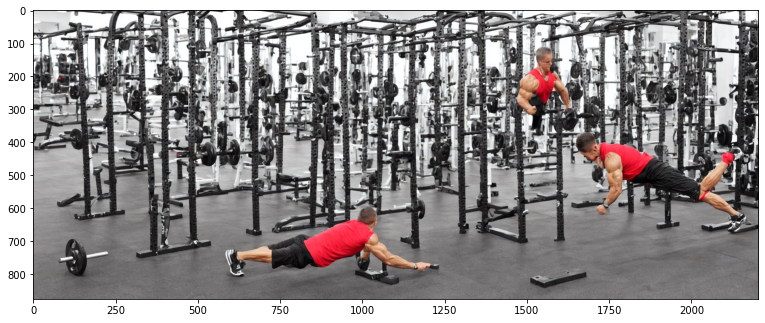

In [11]:
import matplotlib.pyplot as plt
import numpy as np

out_image = output.images[0].resize((2204, 876))

plt.figure(figsize=(13,9))
plt.imshow(out_image)
plt.show()

In [12]:
plt.imsave("banner.png", np.array(out_image))

In [212]:
from diffusers import StableDiffusionPipeline


pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

steps = 100
scale = 9
num_images_per_prompt = 1
seed = 59
generator = torch.Generator(device=device).manual_seed(seed)

desc_most_popular = "protein anton push-ups muscle channel"

output = pipe(
    [f"High Quality Icon {desc_most_popular}"],
    negative_prompt=["blurry, dark photo, blue, nsfw content, text"],
    height=800, width=800,
    num_inference_steps=steps,
    guidance_scale=scale,
    num_images_per_prompt=num_images_per_prompt,
    generator=generator
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/100 [00:00<?, ?it/s]

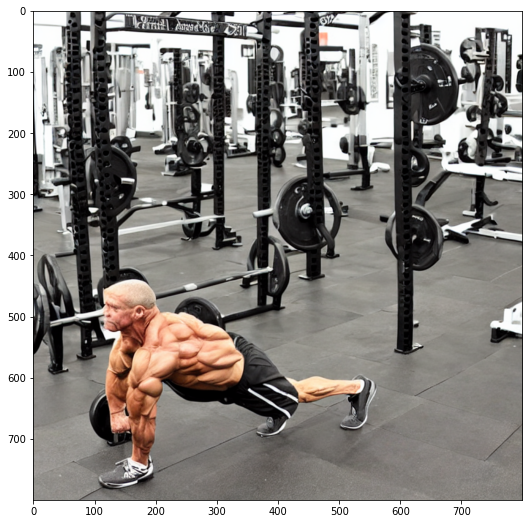

In [213]:
out_image = output.images[0]

plt.figure(figsize=(13,9))
plt.imshow(out_image)
plt.show()